##  Multi-Modal DNN with Compression

The goal of this notebook is to explore multi-modal DNN model [1] as it applies to App intent classification (e.g. work vs play or commercial vs personal app usage) based on multi-modal inputs: URLs and Apps.

An additional goal is to compress the model via pruning and quantization

Let's start by importing the required libraries

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import re
import csv
import math
import codecs
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer 
from nltk.stem import SnowballStemmer

import onnxmltools
import tensorflow as tf
from tensorflow_model_optimization.sparsity import keras as sparsity

l = tf.keras.layers
os.environ['TF_KERAS'] = '1'

import warnings
warnings.filterwarnings('ignore')

In [2]:
import keras
from keras import Input
from keras import optimizers
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, concatenate
from keras.layers import Bidirectional, Embedding, LSTM

from keras.utils import np_utils
from keras.utils import plot_model
from keras.datasets import reuters
from keras.models import load_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

from tqdm import tqdm

In [3]:
def step_decay(epoch):
    lr_init = 0.001
    drop = 0.5
    epochs_drop = 4.0
    lr_new = lr_init * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr_new

In [4]:
class LR_hist(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

In [5]:
#load embeddings
print('loading FastText word embeddings...')
EMBEDDING_DIR = './data/'
embeddings_index = {}
f = codecs.open(os.path.join(EMBEDDING_DIR, 'wiki-news-300d-1M-subword.vec'), encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading FastText word embeddings...


999995it [02:09, 7715.49it/s]


found 999995 word vectors


In [6]:
print("loading URLs dataset...")
url_df = pd.read_csv("./data/URL.csv", header=None)
url_df.columns = ['index', 'url', 'category']
url_df.dropna(inplace=True)
url_df.tail()

loading URLs dataset...


,index,url,category
1562973,1562974,http://www.maxpreps.com/,Sports
1562974,1562975,http://www.myscore.com/,Sports
1562975,1562976,http://sportsillustrated.cnn.com/highschool,Sports
1562976,1562977,http://rss.cnn.com/rss/si_highschool?format=xml,Sports
1562977,1562978,http://www.usatoday.com/sports/preps/,Sports


Let's visualize the category label distribution (TODO: retreive the title of the URL page):

([<matplotlib.axis.XTick at 0x1b1b4825748>,
 <a list of 15 Text xticklabel objects>)

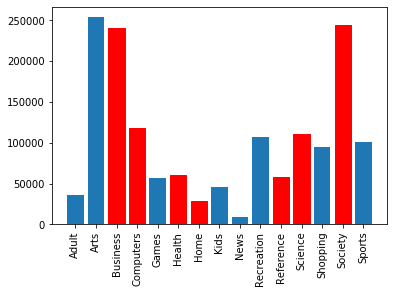

In [7]:
cnt = Counter(url_df['category'])
idx = range(len(cnt))
barlist = plt.bar(idx, cnt.values()) #legend: red (work), blue (play)
barlist[2].set_color('r'); barlist[3].set_color('r'); barlist[5].set_color('r'); barlist[6].set_color('r')
barlist[10].set_color('r'); barlist[11].set_color('r'); barlist[13].set_color('r')
plt.xticks(idx, cnt.keys(), rotation=90)

In [8]:
#text pre-processing
MAX_NB_WORDS = 1e6
tokenizer_nltk = RegexpTokenizer(r'[a-zA-Z]+')
stop_words = set(stopwords.words('english'))
stop_words.update(['http', 'https', 'www', 'com', 'html', 'org', 'ru', 'jp', 'uk', 'ca', '//'])
#stemmer = SnowballStemmer('english')

In [9]:
url_df['url_tokens'] = url_df['url'].apply(lambda x: tokenizer_nltk.tokenize(x))
url_df['url_tokens_filtered'] = url_df['url_tokens'].apply(lambda sent: [word for word in sent if word not in stop_words])
url_df.tail()

,index,url,category,url_tokens,url_tokens_filtered
1562973,1562974,http://www.maxpreps.com/,Sports,"[http, www, maxpreps, com]",[maxpreps]
1562974,1562975,http://www.myscore.com/,Sports,"[http, www, myscore, com]",[myscore]
1562975,1562976,http://sportsillustrated.cnn.com/highschool,Sports,"[http, sportsillustrated, cnn, com, highschool]","[sportsillustrated, cnn, highschool]"
1562976,1562977,http://rss.cnn.com/rss/si_highschool?format=xml,Sports,"[http, rss, cnn, com, rss, si, highschool, for...","[rss, cnn, rss, si, highschool, format, xml]"
1562977,1562978,http://www.usatoday.com/sports/preps/,Sports,"[http, www, usatoday, com, sports, preps]","[usatoday, sports, preps]"


In [10]:
url_df.loc[1562976, 'url']

'http://rss.cnn.com/rss/si_highschool?format=xml'

Let's define a mapping between URL categories and work / play label:

In [11]:
label_df = pd.DataFrame({'category_name': list(cnt.keys()), 
                         'workplay_name':  ['p','p','w','w','p','w','w','p','p','p','w','w','p','w','p'],
                         'workplay_label': ['0','0','1','1','0','1','1','0','0','0','1','1','0','1','0'],
                        })
label_df.head(15)

,category_name,workplay_name,workplay_label
0,Adult,p,0
1,Arts,p,0
2,Business,w,1
3,Computers,w,1
4,Games,p,0
5,Health,w,1
6,Home,w,1
7,Kids,p,0
8,News,p,0
9,Recreation,p,0


In [12]:
label_map_url = {'Adult': 0, 'Arts': 0, 'Business': 1, 'Computers': 1, 'Games': 0, 'Health': 1,
                 'Home': 1, 'Kids': 0, 'News': 0, 'Recreation': 0, 'Reference': 1, 'Science': 1,
                 'Shopping': 0, 'Society': 1, 'Sports': 0}

In [13]:
url_df['target'] = url_df['category'].map(label_map_url)
url_df.tail()

,index,url,category,url_tokens,url_tokens_filtered,target
1562973,1562974,http://www.maxpreps.com/,Sports,"[http, www, maxpreps, com]",[maxpreps],0
1562974,1562975,http://www.myscore.com/,Sports,"[http, www, myscore, com]",[myscore],0
1562975,1562976,http://sportsillustrated.cnn.com/highschool,Sports,"[http, sportsillustrated, cnn, com, highschool]","[sportsillustrated, cnn, highschool]",0
1562976,1562977,http://rss.cnn.com/rss/si_highschool?format=xml,Sports,"[http, rss, cnn, com, rss, si, highschool, for...","[rss, cnn, rss, si, highschool, format, xml]",0
1562977,1562978,http://www.usatoday.com/sports/preps/,Sports,"[http, www, usatoday, com, sports, preps]","[usatoday, sports, preps]",0


In [14]:
num_train = 100000 #int(0.8*len(dataset['target']))  #should match num_train of App dataset!
url_train_df = url_df.sample(n=num_train, random_state=1)
#url_test_df = url_df.sample(n=num_train, random_state=1)
raw_docs_train = url_train_df['url_tokens_filtered']
#raw_docs_test = url_test_df['url_tokens_filtered']
label_train = url_train_df['target'].values
#label_test = url_test_df['target'].values
num_labels = len(np.unique(label_train))
print("{} training examples, {} test examples and {} unique labels".format(num_train, len(url_train_df['target'])-num_train, num_labels))

100000 training examples, 0 test examples and 2 unique labels


In [15]:
url_train_df.to_csv('./data/URL_data_downsampled.csv')

In [16]:
print("pre-processing train docs...")
processed_docs_train = []

for doc in raw_docs_train:
    tokens = tokenizer_nltk.tokenize(" ".join(doc))
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

pre-processing train docs...


In [17]:
print("pre-processing test docs...")
processed_docs_test = []

#for doc in raw_docs_test:
#    tokens = tokenizer.tokenize(doc)
#    filtered = [word for word in tokens if word not in stop_words]
#    processed_docs_test.append(" ".join(filtered))

pre-processing test docs...


In [18]:
print("tokenizing input data...")
tokenizer_keras = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer_keras.fit_on_texts(processed_docs_train + processed_docs_test)
word_seq_train = tokenizer_keras.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer_keras.texts_to_sequences(processed_docs_test)
word_index = tokenizer_keras.word_index
print("dictionary size: ", len(word_index))

tokenizing input data...
dictionary size:  104051


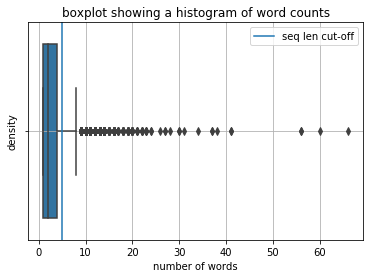

In [19]:
word_id_len = [len(item.split(" ")) for item in processed_docs_train]
max_seq_len = np.round((np.mean(word_id_len) + np.std(word_id_len))).astype(int)
sns.boxplot(word_id_len); plt.axvline(x=max_seq_len, label='seq len cut-off');
plt.title("boxplot showing a histogram of word counts"); plt.xlabel('number of words'); plt.ylabel('density');
plt.grid(True); plt.legend();

In [20]:
#pad sequences
print("padding sequences with max seq len {} words ".format(max_seq_len))
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
#word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)
y_url = label_train
#y_test_enc = label_test_mapped

padding sequences with max seq len 5 words 


In [21]:
word_seq_train.shape

(100000, 5)

In [22]:
len(y_url)

100000

Let's start by exploring the App dataset

In [23]:
app_df = pd.read_csv("./data/Data_AppInteractivitySampleRate02.csv")
app_df.dropna(inplace=True)
app_df.columns = ['DeviceId', 'IndustrySegment', 'DeviceSampleRate', 'IsCommercial', 'AppName']
app_df.head()

,DeviceId,IndustrySegment,DeviceSampleRate,IsCommercial,AppName
0,g:6755399441213943,Consumer,0.0,False,4DF9E0F8.NETFLIX_MCM4NJQHNHSS8
1,g:6755399441213943,Consumer,0.0,False,APPLICATIONCLIPSERVICE.EXE
2,g:6755399441213943,Consumer,0.0,False,BA3D8596-3946-4095-ADCE-6D76E101746F_ZJR0DFHGJ...
3,g:6755399441213943,Consumer,0.0,False,BLACKDESERT_QT5FDT83CBZYC
4,g:6755399441213943,Consumer,0.0,False,CSRSS.EXE


We can sample by DeviceId, i.e. groupby DeviceID, get a list of apps and sort by the number of Apps, then select devices that have more than 1 app and take the number of examples that matches the number of URL training samples

In [24]:
app_df_grouped = app_df.groupby(['DeviceId', 'IsCommercial']).apply(lambda x: x['AppName'].values).reset_index()
app_df_grouped.columns = ['DeviceId', 'IsCommercial', 'AppName']
app_df_grouped['AppLen'] = app_df_grouped['AppName'].apply(len)
app_df_grouped = app_df_grouped.sort_values(by=['AppLen'], ascending=False)

In [25]:
app_df_filtered = app_df_grouped[app_df_grouped['AppLen'] > 50]
#app_df_filtered2 = app_df_grouped[app_df_grouped['AppLen'] == 1].sample(n=83138, random_state=1)
#app_df_filtered = pd.concat([app_df_filtered1, app_df_filtered2], ignore_index=True, sort=False)
app_df_filtered_work = app_df_filtered[app_df_filtered['IsCommercial'] == True]
app_df_filtered_play = app_df_filtered[app_df_filtered['IsCommercial'] == False]
app_df_filtered.head(5)

,DeviceId,IsCommercial,AppName,AppLen
603555,g:6966502931801840,False,"[(MACROGAMER).EXE, 14832CH.EXE, 3.5.5_45311.EX...",552
419469,g:6896137367976978,False,"[0_124977362_GARENA-V2.0.1907.0210.EXE, 3.5.5_...",431
300811,g:6825776021537454,True,"[4DF9E0F8.NETFLIX_MCM4NJQHNHSS8, ACAD.EXE, ACR...",301
660933,s:1052AA03-4848-4857-8006-2B76CBCC0515,True,"[7ZG.EXE, ACROBAT.EXE, ACRORD32.EXE, AGENTPORT...",261
322494,g:6825779716653797,False,"[4DF9E0F8.NETFLIX_MCM4NJQHNHSS8, 7ZFM.EXE, 911...",241


In [26]:
work_apps_list = app_df_filtered_work['AppName'].apply(pd.Series).stack().tolist()
play_apps_list = app_df_filtered_play['AppName'].apply(pd.Series).stack().tolist()
print(work_apps_list[:5])
print(play_apps_list[:5])

['4DF9E0F8.NETFLIX_MCM4NJQHNHSS8', 'ACAD.EXE', 'ACROBAT.EXE', 'ACRORD32.EXE', 'ACROTRAY.EXE']
['(MACROGAMER).EXE', '14832CH.EXE', '3.5.5_45311.EXE', '360CLEANHELPER.EXE', '360DAYPOP.EXE']


In [27]:
app_df_sampled = pd.DataFrame(work_apps_list[:50000] + play_apps_list[:50000])
app_df_sampled.columns=['AppName']
app_df_sampled['IsCommercial'] = [True if i <= 50000 else False for i in range(100000)]

In [29]:
app_df_sampled.to_csv('./data/App_data_downsampled.csv')

In [30]:
app_df_sampled['app'] = app_df_sampled['AppName'].apply(lambda x: x.lower()) #convert all app names to lower case
app_df_sampled['target'] = app_df_sampled['IsCommercial'].apply(lambda x: 1 if x else 0)
app_df_sampled.drop(['AppName', 'IsCommercial'], axis=1, inplace=True)
app_df_sampled.head(10)

,app,target
0,4df9e0f8.netflix_mcm4njqhnhss8,1
1,acad.exe,1
2,acrobat.exe,1
3,acrord32.exe,1
4,acrotray.exe,1
5,adobe desktop service.exe,1
6,almon.exe,1
7,amps.exe,1
8,aoldesktop.exe,1
9,applicationframehost.exe,1


In [32]:
app_df_sampled['app'] = app_df_sampled['app'].apply(lambda x: x.split('_')[0])  #remove anything after underscore, e.g. microsoft.microsoftedge_8wekyb3d8bbwe
app_df_sampled['app'] = app_df_sampled['app'].apply(lambda x: x.split('.')[-1] + '.exe' if ('exe' not in x.split('.')) else x) #keep what remains after the last period + '.exe', e.g. microsoftedge.exe
app_df_sampled.head(10)

,app,target
0,netflix.exe,1
1,acad.exe,1
2,acrobat.exe,1
3,acrord32.exe,1
4,acrotray.exe,1
5,adobe desktop service.exe,1
6,almon.exe,1
7,amps.exe,1
8,aoldesktop.exe,1
9,applicationframehost.exe,1


In [33]:
cnt_app = Counter(app_df_sampled['app'])
idx_app = range(len(cnt_app))
cnt_app.most_common(20)

[('tmp.exe', 1612),
 ('explorer.exe', 1243),
 ('csrss.exe', 1242),
 ('logonui.exe', 1240),
 ('shellexperiencehost.exe', 1236),
 ('cortana.exe', 1226),
 ('applicationframehost.exe', 1192),
 ('dwm.exe', 1146),
 ('taskhostw.exe', 1118),
 ('immersivecontrolpanel.exe', 1043),
 ('lockapp.exe', 906),
 ('microsoftedge.exe', 891),
 ('windowsstore.exe', 857),
 ('conhost.exe', 853),
 ('consent.exe', 838),
 ('rundll32.exe', 802),
 ('chrome.exe', 755),
 ('inputapp.exe', 741),
 ('onedrive.exe', 724),
 ('igfxem.exe', 648)]

Let's look at the level of ambiguity between the Apps, i.e. at an intersection between work and play Apps:

In [34]:
#app_work_df = app_df[app_df['target'] == True]
#app_play_df = app_df[app_df['target'] == False]
#app_intersection = set.intersection(set(app_work_df['app'].values), set(app_play_df['app'].values))
#print("number of apps labeled both work and play: ", len(app_intersection))
#print(np.random.choice(list(app_intersection), 10))

In [35]:
y_app = app_df_sampled['target'].values #binary target variable should match the target variable for URL dataset!
enc = OneHotEncoder(handle_unknown='ignore', sparse=True)
enc.fit(app_df_sampled['app'].values.reshape(-1,1))
X1_train = enc.transform(app_df_sampled['app'].values.reshape(-1,1))
num_features1 = X1_train.shape[1]
X1_train.shape

(100000, 14178)

In [36]:
tosave_df = pd.DataFrame(enc.categories_[0])
tosave_df.to_csv("./data/onehot_encoder_dictionary.csv")

In [37]:
onehot_encoder_dictionary = enc.categories_[0]
enc_new = OneHotEncoder(categories=[onehot_encoder_dictionary])
enc_new.fit(app_df_sampled['app'].values.reshape(-1,1))
X1_train_new = enc_new.transform(app_df_sampled['app'].values.reshape(-1,1))
np.sum(X1_train - X1_train_new) #0 error between new and original one-hot encoder

0.0

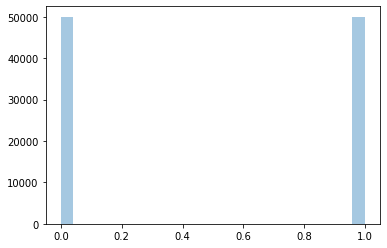

In [38]:
sns.distplot(y_app, kde=False)

Next, let's define our multi-modal NN using the functional keras API

In [39]:
#training params
batch_size = 512
num_epochs = 16

In [40]:
#model parameters
hidden_size_lstm = 32
embed_dim = 300
lstm_dropout = 0.2
dense_dropout = 0.2
weight_decay = 1e-4
nb_words = min(MAX_NB_WORDS, len(word_index)+1)

In [41]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: ', len(words_not_found))

preparing embedding matrix...
number of null word embeddings:  83470


In [42]:
embedding_matrix.shape

(104052, 300)

In [43]:
print("sample words not found in the embeddings:\n", np.random.choice(words_not_found, 20))

sample words not found in the embeddings:
 ['chickenstock' 'gateprotect' 'woodplan' 'whitewolf' 'needleworkbooks'
 'sfid' 'krud' 'southwindsorsoccer' 'verdewaldo' 'iflexresource'
 'seniorfitness' 'accuratesundials' 'energysoftworx' 'kamain'
 'borealbrewers' 'sleague' 'cambridgeconsult' 'alexandermacleod' 'sklavin'
 'xxxgayporn']


In [44]:
num_train_samples = 100000
end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * num_epochs
print(end_step)

3136


Let's apply model optimization to reduce model size (NOTE: do not mix pure keras with tf.keras, this will result in errors due to version mismatches / different libraries)

In [45]:
pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=100)}

In [46]:
#multi-modal NN

#MLP branch
mlp_model = tf.keras.Sequential([
    l.Input(shape=(num_features1,), name='app'),
    sparsity.prune_low_magnitude(l.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
                                 **pruning_params),
    sparsity.prune_low_magnitude(l.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
                                 **pruning_params),
    sparsity.prune_low_magnitude(l.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
                                 **pruning_params)
])

#LSTM branch
lstm_model = tf.keras.Sequential([
    l.Input(shape=(max_seq_len,), name='url'),
    l.Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False),
    l.Bidirectional(l.LSTM(hidden_size_lstm, dropout=lstm_dropout, recurrent_dropout=lstm_dropout))
])

merged = l.concatenate([mlp_model.output, lstm_model.output], axis=-1)
z = l.Dropout(dense_dropout)(merged)
z = l.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(z)
output = l.Dense(1, activation='sigmoid')(z)

pruned_model = tf.keras.Model([mlp_model.input, lstm_model.input], output)
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, clipnorm=1.0)
pruned_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
pruned_model.summary()

W0814 14:04:17.401700 18484 deprecation.py:506] From C:\Users\t-vasmol.REDMOND\AppData\Local\Continuum\anaconda3\envs\vss\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0814 14:04:17.410701 18484 deprecation.py:323] From C:\Users\t-vasmol.REDMOND\AppData\Local\Continuum\anaconda3\envs\vss\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:185: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.
W0814 14:04:17.697701 18484 deprecation.py:323] From C:\Users\t-vasmol.REDMOND\AppData\Local\Continuum\anaconda3\envs\vss\lib\site-packages\tens

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
app (InputLayer)                [(None, 14178)]      0                                            
__________________________________________________________________________________________________
prune_low_magnitude_dense (Prun (None, 512)          14518786    app[0][0]                        
__________________________________________________________________________________________________
url (InputLayer)                [(None, 5)]          0                                            
__________________________________________________________________________________________________
prune_low_magnitude_dense_1 (Pr (None, 128)          131202      prune_low_magnitude_dense[0][0]  
______________________________________________________________________________________________

In [56]:
#define callbacks
SAVE_PATH = "./data/"
file_name = SAVE_PATH + 'dnn-weights-checkpoint-v6.h5'
checkpoint = ModelCheckpoint(file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#tensor_board = TensorBoard(log_dir='./logs', write_graph=True)
hist_lr = LR_hist()
reduce_lr = LearningRateScheduler(step_decay) 
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=8, verbose=1)
#callbacks_list = [checkpoint, hist_lr, reduce_lr, early_stopping, sparsity.UpdatePruningStep()]
callbacks_list = [sparsity.UpdatePruningStep()]

Define the training label to be an OR between App label and the URL label to bias the training data towards work:

In [53]:
y_train = y_url | y_app

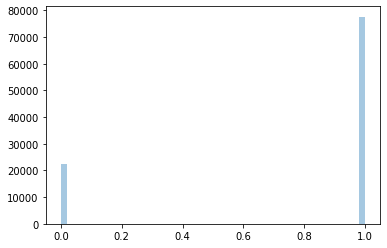

In [54]:
sns.distplot(y_train, kde=False)

In [55]:
hist = pruned_model.fit({'app': X1_train, 'url': word_seq_train}, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Train on 90000 samples, validate on 10000 samples
Epoch 1/16
Epoch 1/16
90000/90000 - 59s - loss: 0.5220 - acc: 0.7998 - val_loss: 0.8243 - val_acc: 0.5479
Epoch 2/16
Epoch 1/16
90000/90000 - 54s - loss: 0.4801 - acc: 0.8027 - val_loss: 0.8009 - val_acc: 0.5542
Epoch 3/16
Epoch 1/16
90000/90000 - 53s - loss: 0.4717 - acc: 0.8050 - val_loss: 0.7879 - val_acc: 0.5721
Epoch 4/16
Epoch 1/16
90000/90000 - 56s - loss: 0.4631 - acc: 0.8075 - val_loss: 0.8071 - val_acc: 0.5735
Epoch 5/16
Epoch 1/16
90000/90000 - 53s - loss: 0.4519 - acc: 0.8100 - val_loss: 0.8320 - val_acc: 0.5769
Epoch 6/16
Epoch 1/16
90000/90000 - 56s - loss: 0.4448 - acc: 0.8118 - val_loss: 0.8384 - val_acc: 0.5758
Epoch 7/16
Epoch 1/16
90000/90000 - 55s - loss: 0.4373 - acc: 0.8134 - val_loss: 0.8403 - val_acc: 0.5829
Epoch 8/16
Epoch 1/16
90000/90000 - 54s - loss: 0.4329 - acc: 0.8148 - val_loss: 0.8775 - val_acc: 0.5785
Epoch 9/16
Epoch 1/16
90000/90000 - 55s - loss: 0.4273 - acc: 0.8194 - val_loss: 0.8313 - val_acc: 0.5

In [57]:
final_model = sparsity.strip_pruning(pruned_model)
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
app (InputLayer)                [(None, 14178)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          7259648     app[0][0]                        
__________________________________________________________________________________________________
url (InputLayer)                [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          65664       dense[0][0]                      
______________________________________________________________________________________________

In [58]:
tf.keras.models.save_model(final_model, file_name, include_optimizer=False)

In [60]:
compression_data = []
for i, w in enumerate(final_model.get_weights()):
    #print("{} -- Total:{}, Zeros: {:.2f}%".format(
    #        model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100))
    compression_data.append([final_model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100])
#end for
compression_df = pd.DataFrame(compression_data)
compression_df.columns = ['layer_name', 'num_parameters', 'compression_percent']
compression_df

,layer_name,num_parameters,compression_percent
0,prune_low_magnitude_dense/kernel:0,7259136,89.950801
1,prune_low_magnitude_dense/bias:0,512,0.000000
2,prune_low_magnitude_dense_1/kernel:0,65536,89.950562
3,prune_low_magnitude_dense_1/bias:0,128,0.000000
4,embedding/embeddings:0,31215600,80.262862
5,prune_low_magnitude_dense_2/kernel:0,4096,89.941406
6,prune_low_magnitude_dense_2/bias:0,32,0.000000
7,bidirectional/forward_lstm/kernel:0,38400,0.000000
8,bidirectional/forward_lstm/recurrent_kernel:0,4096,0.000000
9,bidirectional/forward_lstm/bias:0,128,0.000000


In [ ]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], c='b', lw=2.0, label='train')
plt.plot(hist.history['val_loss'], c='r', lw=2.0, label='val')
plt.title('Multi-Modal DNN model')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('./figures/dnn_loss.png')

In [ ]:
plt.figure()
plt.plot(hist.history['acc'], c='b', lw=2.0, label='train')
plt.plot(hist.history['val_acc'], c='r', lw=2.0, label='val')
plt.title('Multi-Modal DNN model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig('./figures/dnn_acc.png')

In [ ]:
plt.figure()
plt.plot(hist_lr.lr, lw=2.0, label='learning rate')
plt.title('Multi-Moodal DNN Model')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)
plt.savefig('./figures/dnn_learning_rate.png')

Let's add model quantization to further reduce its size (NOTE: currently merge operation is not supported to TFlite)

In [ ]:
#pruned_keras_file = "./data/dnn-weights-checkpoint-v4.h5"
#tflite_model_file = "./data/dnn-weights-checkpoint-v4.tflite"
#converter = tf.lite.TFLiteConverter.from_keras_model_file(pruned_keras_file)
#converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
#tflite_model = converter.convert()
#with open(tflite_model_file, "wb") as f:
#    f.write(tflite_model)

Let's load the trained model and predict on user test session data next:

In [78]:
dnn_model = tf.keras.models.load_model('./data/dnn-weights-checkpoint-v6.h5')
dnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
app (InputLayer)                [(None, 14178)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          7259648     app[0][0]                        
__________________________________________________________________________________________________
url (InputLayer)                [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          65664       dense[0][0]                      
______________________________________________________________________________________________

In [63]:
print("loading and pre-processing App test data...")
app_test_df = pd.read_csv('./data/AppResult.csv', sep=',')
app_test_df['target'] = app_test_df['Label'].map({'work': 1, 'play': 0})
y_app_test = app_test_df['target'].values

#use the one-hot encoder fit on all apps to transform existing test apps
X1_test = enc.transform(app_test_df['Process'].values.reshape(-1,1)) 
X1_test.shape

loading and pre-processing App test data...


(1604, 14178)

In [64]:
print("loading and pre-processing URL test data...")
url_test_df = pd.read_csv("./data/URLResult.csv")
url_test_df.columns = ['index', 'url', 'category']
url_test_df.dropna(inplace=True)

url_test_df['url_tokens'] = url_test_df['url'].apply(lambda x: tokenizer_nltk.tokenize(x))
url_test_df['url_tokens_filtered'] = url_test_df['url_tokens'].apply(lambda sent: [word for word in sent if word not in stop_words])
url_test_df['target'] = url_test_df['category'].map({'work': 1, 'play': 0})

num_train = X1_test.shape[0]  #to match input lengths
url_test_df = url_test_df.sample(n=num_train, replace=True, random_state=1)
raw_docs_test = url_test_df['url_tokens_filtered']
y_url_test = url_test_df['target'].values

processed_docs_test = []
for doc in raw_docs_test:
    tokens = tokenizer_nltk.tokenize(" ".join(doc))
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

word_seq_test = tokenizer_keras.texts_to_sequences(processed_docs_test)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)
word_seq_test.shape


loading and pre-processing URL test data...


(1604, 5)

In [65]:
y_label_test = y_url_test | y_app_test

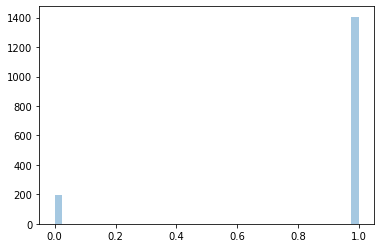

In [66]:
sns.distplot(y_label_test, kde=False)

Let's evaluate the model on test data next:

In [103]:
score_prob = dnn_model.predict({'app': X1_test, 'url': word_seq_test}, batch_size=32, verbose=1)
score_threshold = 0.7
score_final = list(map(lambda x: 1 if x > score_threshold else 0, score_prob))

1604/1604 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 868us/sample


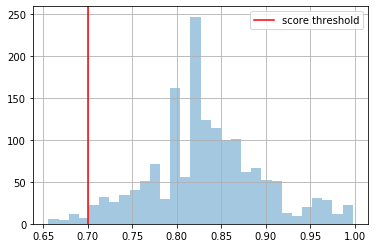

In [104]:
sns.distplot(score_prob, kde=False)
plt.axvline(x=score_threshold, c='r', label='score threshold'); plt.grid(True); plt.legend()

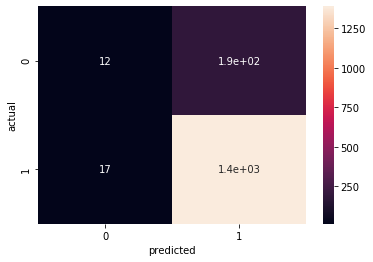

In [105]:
score_data = {'y_pred': score_final, 'y_true': y_label_test}

score_df = pd.DataFrame(score_data, columns=['y_true','y_pred'])
confusion_matrix = pd.crosstab(score_df['y_true'], score_df['y_pred'], rownames=['actual'], colnames=['predicted'])

sns.heatmap(confusion_matrix, annot=True)

In [106]:
clf_acc = np.trace(confusion_matrix.values)/sum(sum(confusion_matrix.values))
print("classification accuracy: ", clf_acc)

classification accuracy:  0.8734413965087282


Let's export the model into ONNX format

In [98]:
# Load your Keras model
keras_model = tf.keras.models.load_model('./data/dnn-weights-checkpoint-v6.h5')

print(isinstance(keras_model, tf.keras.Model))
# Convert the Keras model into ONNX
onnx_model = onnxmltools.convert_keras(keras_model)

# Save as protobuf
onnxmltools.utils.save_model(onnx_model, './data/model-v6.onnx')

1
True


Exception: This is a tensorflow keras model, but keras standalone converter is used. Please set environment variable TF_KERAS = 1.

### References

[1] Francois Chollet, "Deep Learning with Python", 2017  
[2] https://www.dlology.com/blog/how-to-compress-your-keras-model-x5-smaller-with-tensorflow-model-optimization/  
[3] https://www.dlology.com/blog/how-to-convert-trained-keras-model-to-tensorflow-and-make-prediction/

